# CS7290 Causal Modeling in Machine Learning: Homework 3

## Smruthi Ramesh

### Topics

• Recognizing valid adjustment sets

• Covariate adjustment with parent and back-door criterion 

• Front-door criterion

• Propensity matching and inverse probability weighting

• Intro to structural causal models

In [6]:
from IPython.display import Image

#Pyro imports

import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro
import pyro.distributions as dist
import pandas as pd
import random

pyro.set_rng_seed(100)

### Question 1: Valid adjustment sets

#### 1.1 The following DAG represents a causal model of user behavior in an app.

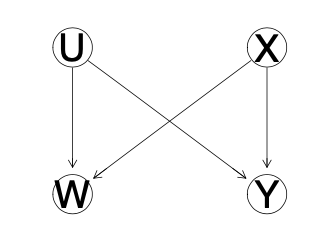

In [2]:
Image(filename='1.png')

#### U represents the user specific preferences. X represents the introduction of a feature designed to make users make certain in-app purchases, Y was whether or not the user made the purchase, W represents app usage after the feature is introduced.

#### 1.1.a You are interested in estimating the causal effect of X on Y. What is the valid adjustment set? Valid adjustment set is the set of variables that if you adjust, you will get the unbiased results. (3 points)

The valid adjustment set here is the null set. 

This is because there is no other backdoor path.

#### 1.1.b What would happen if you adjusted for W? Be specific. (2 points)

If we adjusted for $W$, this will activate the path $U\leftarrow W\rightarrow X$ and therefore there would be a backdoor path to $Y$.

#### 1.1.c Suppose you want to assess the effect of X on Y for users who go on to have a high amount of app usage. Fill in the blanks on the right-hand-side and left-hand-side for the adjustment formula of interest:

$$P(Y=y|do(X=x), W=high) = \sum_{?}P(Y=y|?)P(?|?)$$

$$P(Y=y|do(X=x),W=high) = \sum_{u}P(Y=y|X=x, W=high, U=u)P(U=u|W=high)$$

#### 1.2 Consider the following DAG.

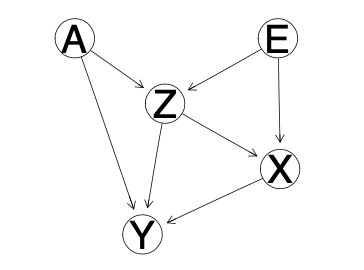

In [3]:
Image(filename='12.png')

#### You are interest in estimating the causal effect of X on Y.

#### 1.2.a Is the set containing only Z a valid adjustment set? Why or why not? (2 points)

No. Conditioning on $Z$ alone makes the collider $A\rightarrow Z \leftarrow E$ active, so we need to condition either on $A$ or $E$ as well.

#### 1.2.b List all of the adjustment sets that blocks all the back doors(there are three) and write the adjustment formula for each adjustment set. (3 points)

So the adjustment sets are $\{Z,E\}, \{Z,A\}, \{A,E,Z\}$

Formulas are $\sum_{z,e}P(Y=y|X=x,Z=z,E=e)P(Z=z|E=e)P(E=e)$

$\sum_{z,a}P(Y=y|X=x,A=a,Z=z)P(Z=z|A=a)P(A=a)$

and $\sum_{a,e,z}P(Y=y|X=x,A=a,E=e,Z=z)P(Z=z|A=a,E=e)P(A=a)P(E=e)$

#### 1.2.c Suppose that E and A are both observable, but observing E costs \\$10 per data point and observing A costs \\$5 per data point. Which conditioning set do you go with? (1 point)

It's best to go with the set $\{Z,A\}$.

#### 1.3 Consider the following DAG:

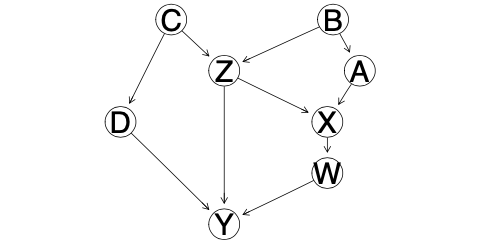

In [4]:
Image(filename='13.png')

#### 1.3.a List all of the sets of variables that satisfy the backdoor criterion to determine the causal effect of X on Y. (3 points)

$$
\{A,Z\}\\
\{B,Z\}\\
\{C,Z\}\\
\{D,Z\}\\
\{A,B,Z\}\\
\{A,C,Z\}\\
\{A,D,Z\}\\
\{B,C,Z\}\\
\{B,D,Z\}\\
\{C,D,Z\}\\
\{A,B,C,Z\}\\
\{A,B,D,Z\}\\
\{B,C,D,Z\}\\
\{A,C,D,Z\}\\
\{A,B,C,D,Z\}
$$

#### 1.3.b List all of the minimal sets of variables that satisfy the backdoor criterion to determine the causal effect of X on Y (i.e., any set of variables such that, if you removed any one of the variables from the set, it would no longer meet the criterion). (3 points)

$$
\{A,Z\}\\
\{B,Z\}\\
\{C,Z\}\\
\{D,Z\}\\
$$

#### 1.3.c List all the minimal sets of variables that need to be measured in order to identify the effect of D on Y. (3 points)

The sets are $$
\{C\}\\
\{A,Z\}\\
\{B,Z\}\\
\{X,Z\}\\
\{W,Z\}\\
$$

#### 1.3.d Now suppose we want to know the causal effect of intervening on 2 variables. List all the minimal sets of variables that need to be measured in order to identify the effect of set {D, W} on Y, i.e., P (Y = y|do(D = d), do(W = w)). (3 points)

The sets are
$$
\{Z\}\\
\{C,X\}
$$

### Question 2: Covariate adjustment

#### 2.1.a Build the model with Pyro using the values in the table. Use pyro.condition to calculate the causal effect by adjusting for happiness. (5 points)

In [569]:
#Creating model

def bn():
    #Z = [unhappy, happy]
    Z = pyro.sample("Happiness", dist.Categorical(torch.tensor([0.509,0.491])))
    #X = [promotion 0, promotion 1] -> Z 
    X_probs = torch.tensor([[0.246,0.762],[0.754,0.237]])
    X = pyro.sample("Promotion", dist.Categorical(X_probs[Z]))
    #Y = [not renewed, renewed] -> X, Z
    Y_probs = torch.tensor([[[0.068,0.932],[0.267,0.733]],[[0.131,0.869],[0.313,0.687]]])
    Y = pyro.sample("Renewed", dist.Categorical(Y_probs[X][Z]))

In [570]:
#Conditioning model on B=on, C=on

conditioned_bn_00 = pyro.condition(bn, data={'Promotion':torch.tensor(0), 'Happiness':torch.tensor(0)})
conditioned_bn_01 = pyro.condition(bn, data={'Promotion':torch.tensor(0), 'Happiness':torch.tensor(1)})
conditioned_bn_10 = pyro.condition(bn, data={'Promotion':torch.tensor(1), 'Happiness':torch.tensor(0)})
conditioned_bn_11 = pyro.condition(bn, data={'Promotion':torch.tensor(1), 'Happiness':torch.tensor(1)})

In [571]:
#P(Y|X=0,Z=0)

posterior_00 = pyro.infer.Importance(conditioned_bn_00, num_samples=1000).run()
marginal_00 = pyro.infer.EmpiricalMarginal(posterior_00, "Renewed")
Y_samples_00 = np.array([marginal_00().item() for _ in range(1000)])
p_00 = Y_samples_00.mean()

In [572]:
#P(Y|X=0,Z=1)

posterior_01 = pyro.infer.Importance(conditioned_bn_01, num_samples=1000).run()
marginal_01 = pyro.infer.EmpiricalMarginal(posterior_01, "Renewed")
Y_samples_01 = np.array([marginal_01().item() for _ in range(1000)])
p_01 = Y_samples_01.mean()

In [573]:
#P(Y|X=0)

p_y_x0 = p_00*0.509 + p_01*0.491

In [574]:
#P(Y|X=1,Z=0)

posterior_10 = pyro.infer.Importance(conditioned_bn_10, num_samples=1000).run()
marginal_10 = pyro.infer.EmpiricalMarginal(posterior_10, "Renewed")
Y_samples_10 = np.array([marginal_10().item() for _ in range(1000)])
p_10 = Y_samples_10.mean()

In [575]:
#P(Y|X=1,Z=1)

posterior_11 = pyro.infer.Importance(conditioned_bn_11, num_samples=1000).run()
marginal_11 = pyro.infer.EmpiricalMarginal(posterior_11, "Renewed")
Y_samples_11 = np.array([marginal_11().item() for _ in range(1000)])
p_11 = Y_samples_11.mean()

In [576]:
#P(Y|X=1)

p_1 = p_10*0.509 + p_11*0.491

In [577]:
p_0 - p_1

0.05985900000000011

#### 2.1.b Suppose you could not observe happiness. Use pyro.do to calculate the causal effect with do-calculus. (5 points)

In [582]:
#intervention model

intervened_bn_0 = pyro.do(bn, data={'Promotion':torch.tensor(0)})
intervened_bn_1 = pyro.do(bn, data={'Promotion':torch.tensor(1)})

In [583]:
#P(Y|X=0)

posterior_0 = pyro.infer.Importance(intervened_bn_0, num_samples=1000).run()
marginal_0 = pyro.infer.EmpiricalMarginal(posterior_0, "Renewed")
Y_samples_0 = np.array([marginal_0().item() for _ in range(1000)])
p_0_int = Y_samples_0.mean()

In [584]:
#P(Y|X=1)

posterior_1 = pyro.infer.Importance(intervened_bn_1, num_samples=1000).run()
marginal_1 = pyro.infer.EmpiricalMarginal(posterior_1, "Renewed")
Y_samples_1 = np.array([marginal_1().item() for _ in range(1000)])
p_1_int = Y_samples_1.mean()

In [585]:
p_0_int - p_1_int

0.05899999999999994

#### 2.2 You are a data scientist investigating the effects of social media use on purchasing a product. You assume the dag shown below. User info here is unobserved. One of the team members argues that social media usage does not drive purchase based on Table 1. Only 15% social media user made the purchase, while 90.25% non social media users made the purchase. Moreover, within each group, no-adblock and adblock, social media users show a much lower rate of purchase than non social media users. However, another team member argues that social media usage increases purchases. When we look at each group, social media user and non social media user as show in Table 2 (Table 1 and Table 2 both represent the same dataset), advertisement increases purchases in both groups. Among social media users, purchases increases from 10% to 15% for people who have seen advertisement. Among non social media users, purchases increases from 90% to 95% for people who have seen advertisement. Which view is right?

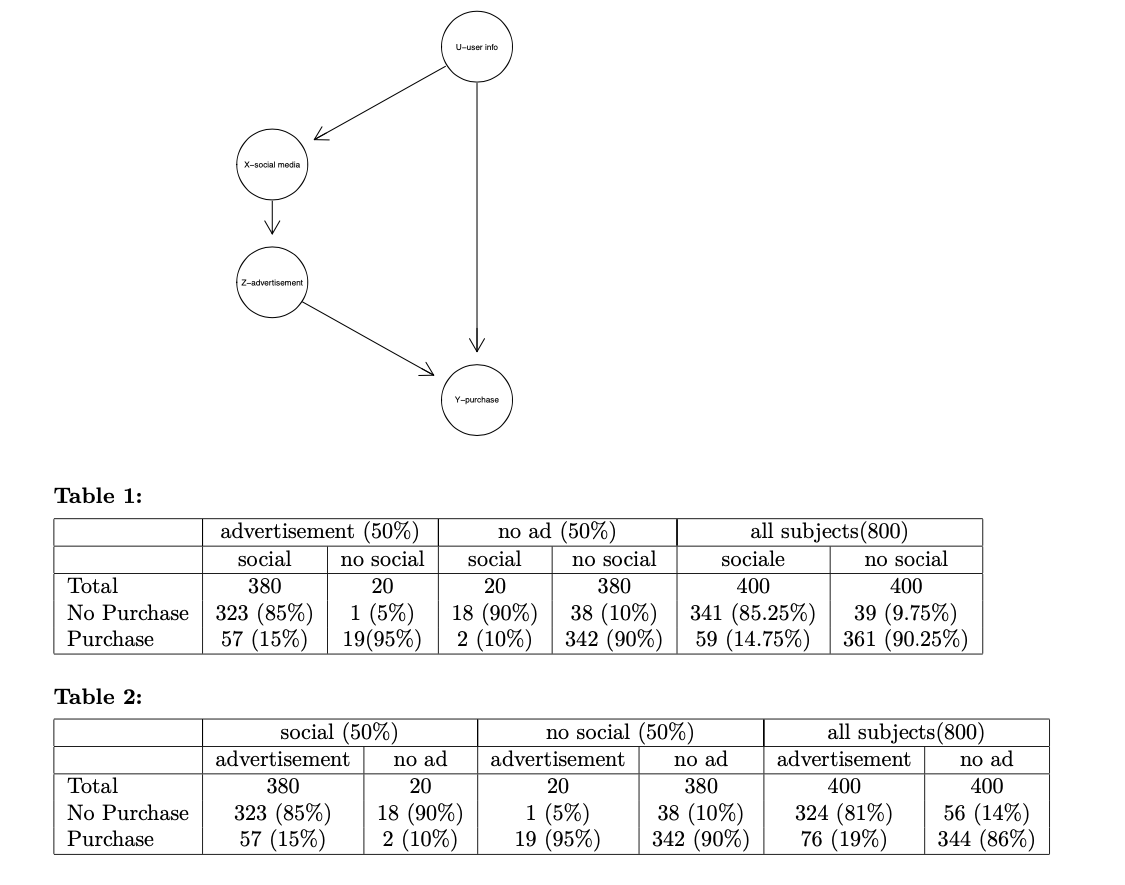

In [21]:
Image(filename='22.png')

#### 2.2.a User info is unobserved. Use pyro.condition to calculate the causal effect of social media on product purchase using front-door adjustment (Section 3.4 in Front Door Criterion).(5 points)

In [586]:
#Creating model

def bn2():
    #X = [no social,social]
    X = pyro.sample("Social", dist.Categorical(torch.tensor([0.5,0.5])))
    #Z = [no ad,ad] -> X
    Z_probs = torch.tensor([[0.95,0.05],[0.05,0.95]])
    Z = pyro.sample("Advertisement", dist.Categorical(Z_probs[X]))
    #Y = [no purchase,purchase] -> Z
    Y_probs = torch.tensor([[0.19,0.81],[0.86,0.14]])
    Y = pyro.sample("Purchase", dist.Categorical(Y_probs[Z]))

In [587]:
conditioned_bn2_00 = pyro.condition(bn2, data={"Social":torch.tensor(0), "Advertisement":torch.tensor(0)})
conditioned_bn2_01 = pyro.condition(bn2, data={"Social":torch.tensor(0), "Advertisement":torch.tensor(1)})
conditioned_bn2_10 = pyro.condition(bn2, data={"Social":torch.tensor(1), "Advertisement":torch.tensor(0)})
conditioned_bn2_11 = pyro.condition(bn2, data={"Social":torch.tensor(1), "Advertisement":torch.tensor(1)})

In [588]:
#P(Y|X=0, Z=0)
posterior2_00 = pyro.infer.Importance(conditioned_bn2_00, num_samples=1000).run()
marginal2_00 = pyro.infer.EmpiricalMarginal(posterior2_00, "Purchase")
Y_samples2_00 = np.array([marginal2_00().item() for _ in range(1000)])
p2_00 = Y_samples2_00.mean()

#P(Y|X=1, Z=0)
posterior2_10 = pyro.infer.Importance(conditioned_bn2_10, num_samples=1000).run()
marginal2_10 = pyro.infer.EmpiricalMarginal(posterior2_10, "Purchase")
Y_samples2_10 = np.array([marginal2_10().item() for _ in range(1000)])
p2_10 = Y_samples2_10.mean()

#P(Y|X=0, Z=1)
posterior2_01 = pyro.infer.Importance(conditioned_bn2_01, num_samples=1000).run()
marginal2_01 = pyro.infer.EmpiricalMarginal(posterior2_01, "Purchase")
Y_samples2_01 = np.array([marginal2_01().item() for _ in range(1000)])
p2_01 = Y_samples2_01.mean()

#P(Y|X=1,Z=1)
posterior2_11 = pyro.infer.Importance(conditioned_bn2_11, num_samples=1000).run()
marginal2_11 = pyro.infer.EmpiricalMarginal(posterior2_11, "Purchase")
Y_samples2_11 = np.array([marginal2_11().item() for _ in range(1000)])
p2_11 = Y_samples2_11.mean()

In [589]:
#P(Y|X=0) = sum_z(P(Z=z|X=0)*sum_x'(P(Y|X=x',Z=z)*P(X=x')))

sum_x_z0 = p2_00*0.5 + p2_10*0.5 
sum_x_z1 = p2_01*0.5 + p2_11*0.5

sum_z0_x0 = 0.95*(sum_x_z0)
sum_z1_x0 = 0.05*(sum_x_z1)

p_y_x0 = sum_z0_x0 + sum_z1_x0

In [590]:
#P(Y|X=1) = sum_z(P(Z=z|X=1)*sum_x(P(Y|X=x,Z=z)*P(X=x)))

sum_z0_x1 = 0.05*(sum_x_z0)
sum_z1_x1 = 0.95*(sum_x_z1)

p_y_x1 = sum_z0_x1 + sum_z1_x1

In [591]:
p_y_x0 - p_y_x1

0.6083999999999999

#### 2.2.b Verify your result using do-calculus with pyro.do.(P (Y = 1|do(X = 0)) − P (Y = 1|do(X = 1))) (5 points)

In [501]:
#intervention models - do(X=0), do(X=1)

intervened_bn2_0 = pyro.do(bn2, data={"Social":torch.tensor(0)})
intervened_bn2_1 = pyro.do(bn2, data={"Social":torch.tensor(1)})

In [502]:
posterior2_0 = pyro.infer.Importance(intervened_bn2_0, num_samples=1000).run()
marginal2_0 = pyro.infer.EmpiricalMarginal(posterior2_0, "Purchase")
Y_samples2_0 = np.array([marginal2_0().item() for _ in range(1000)])
p2_0 = Y_samples2_0.mean()

In [503]:
posterior2_1 = pyro.infer.Importance(intervened_bn2_1, num_samples=1000).run()
marginal2_1 = pyro.infer.EmpiricalMarginal(posterior2_1, "Purchase")
Y_samples2_1 = np.array([marginal2_1().item() for _ in range(1000)])
p2_1 = Y_samples2_1.mean()

In [504]:
p2_0 - p2_1

0.646

As we can see here, social media usage does not drive purchases. Absence of social media has marginally higher purchase percentage than presence.

### Question 3: Inverse probability weighting with a propensity score.

#### 3.1 Use the data in Question 2.1 to create the following propensity score function. (3 points)

##### def propensity(x, z):
     returns P(X = x | Z = z)

In [505]:
def propensity(z,x):
    X_probs = torch.tensor([[0.246,0.762],[0.754,0.237]])
    return X_probs[x][z]

#### 3.2 Use the model from Question 2.1 to generate 1000 samples, along with the sample probabilities. Print the first 10 samples. (3 points)

In [506]:
trace_handler = pyro.poutine.trace(bn) 
samples = []
probs = []
for i in range(1000):
    trace = trace_handler.get_trace() 
    z = trace.nodes['Happiness']['value']
    x = trace.nodes['Promotion']['value']
    y = trace.nodes['Renewed']['value'] 
    log_prob = trace.log_prob_sum()
    p = np.exp(log_prob) 
    samples.append((int(z),int(x),int(y)))
    probs.append(p)

In [507]:
samples[:10]

[(1, 0, 1),
 (1, 1, 1),
 (1, 1, 1),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 1),
 (0, 1, 1),
 (1, 0, 1),
 (1, 0, 1),
 (1, 0, 0)]

#### 3.3 Compute weighted joint probabilities for each possible combinations of X, Y, Z. Hint: Use your propensity function to create a list of weights for each combination, and multiplying original joint probability of each combination by this weight. Normalize the weighted probabilities if they don’t sum up to 1. (3 points) (Refer to Section 3.6 :Inverse Probability Weighting)

In [592]:
prop_score = {}
for z_val in range(0,2):
    for x_val in range(0,2):
        prop_score[(z_val,x_val)] = propensity(z_val,x_val)

In [593]:
prop_score

{(0, 0): tensor(0.2460),
 (0, 1): tensor(0.7540),
 (1, 0): tensor(0.7620),
 (1, 1): tensor(0.2370)}

In [594]:
poss_combs = []
for z_val in range(0,2):
    for x_val in range(0,2):
        for y_val in range(0,2):
            poss_combs.append((z_val,x_val,y_val))

In [595]:
poss_combs

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [596]:
probs_combs = {}
for i in poss_combs:
    if i in samples:
        probs_combs[i] = probs[samples.index(i)]        

In [597]:
probs_combs

{(0, 0, 0): tensor(0.0084),
 (0, 0, 1): tensor(0.1158),
 (0, 1, 0): tensor(0.0504),
 (0, 1, 1): tensor(0.3344),
 (1, 0, 0): tensor(0.0997),
 (1, 0, 1): tensor(0.2738),
 (1, 1, 0): tensor(0.0368),
 (1, 1, 1): tensor(0.0807)}

In [598]:
weights = {}
for i in poss_combs:
    weights[i] = float(probs_combs[i]/prop_score[(i[0],i[1])])

In [599]:
weights

{(0, 0, 0): 0.034337300807237625,
 (0, 0, 1): 0.47062304615974426,
 (0, 1, 0): 0.0668516606092453,
 (0, 1, 1): 0.4434663653373718,
 (1, 0, 0): 0.13089872896671295,
 (1, 0, 1): 0.35935869812965393,
 (1, 1, 0): 0.1550786793231964,
 (1, 1, 1): 0.34038037061691284}

In [600]:
tot = sum(np.array([k[1] for k in weights.items()]))
weights = {k:v/tot for k,v in weights.items()}

#### 3.4 Sample with replacement 1000 samples from the weighted probabilty distribution obtained in Question 3.3. (1 point)

In [688]:
omega = random.choices(poss_combs, list(weights.values()), k=1000)

#### 3.5 Call this new set of samples $\Omega$. Let $p^{\Omega}(X =x)$ be the proportion of times $X == x$ in $\Omega$ and $p^{\Omega}(X = x|Y = y)$ be the proportion of the $\Omega$ samples where $X == x$ after filtering for samples where $Y == y$. If you performed the above inverse probability weighting procedure correctly, then $P^{model}(Y = y|do(X = x)) ≈ p^{\Omega}(Y = y|X = x)$ (the LHS and RHS are equal as the sample size goes to infinity). Confirm this by recalculating the causal effect from Question 2.1 using this method. (3 points)

In [689]:
x0z0 = 0
x1z1 = 0
x0z1 = 0
x1z0 = 0
y1_x0z0 = 0
y1_x0z1 = 0
y1_x1z0 = 0
y1_x1z1 = 0

for i in omega:
    if i[0] == 0:
        if i[1] == 0:
            x0z0 += 1
            if i[2] == 1:
                y1_x0z0 += 1
        else:
            x1z0 += 1
            if i[2] == 1:
                y1_x1z0 += 1
    else:
        if i[1] == 0:
            x0z1 += 1
            if i[2] == 1:
                y1_x0z1 += 1
        else:
            x1z1 += 1
            if i[2] == 1:
                y1_x1z1 += 1

In [690]:
p_y1_x0 = ((y1_x0z0/x0z0)*0.509) + ((y1_x0z1/x0z1)*0.491)
p_y1_x1 = ((y1_x1z0/x1z0)*0.509) + ((y1_x1z1/x1z1)*0.491)

In [691]:
p_y1_x0-p_y1_x1

0.06759394581685818

### Question 4: Structural causal models

#### 4.1 Consider the SCM M:

$$X := N_X\\
Y := X^2 + N_Y\\
N_X, N_Y \sim^{iid} N(0,1)$$

#### Write this model in Pyro and generate 10 samples of X and Y. (3 points)

In [94]:
def model():
    nx = pyro.sample("Nx", dist.Normal(0.0,1.0))
    ny = pyro.sample("Ny", dist.Normal(0.0,1.0))
    x = pyro.sample("x", dist.Delta(nx))
    y = torch.pow(x,2) + ny
    y = pyro.sample('y', dist.Normal(y, 0.01))

In [98]:
posterior4 = pyro.infer.Importance(model, num_samples=1000).run()
marginal4x = pyro.infer.EmpiricalMarginal(posterior4, "x")
marginal4y = pyro.infer.EmpiricalMarginal(posterior4, "y")
x_samples = np.array([marginal4x().item() for _ in range(10)])
y_samples = np.array([marginal4y().item() for _ in range(10)])

In [99]:
x_samples, y_samples

(array([-0.47869331,  0.2195849 , -0.45421913, -0.6728946 ,  0.82336438,
        -0.09986234,  0.97769386,  0.87596768, -2.58669996, -0.93225884]),
 array([ 0.39390168,  0.79080075, -2.54047012, -0.76821786,  0.75480103,
         0.9608956 ,  0.76320165,  4.62954187,  0.47242764, -0.72045314]))

### 4.2 Consider the SCM $M$:
$$X := N_X\\
Y := 4X + N_Y\\
N_X, N_Y ∼^{iid} N(0, 1)$$


#### 4.2.a Draw a picture of the model’s DAG.(1 point)

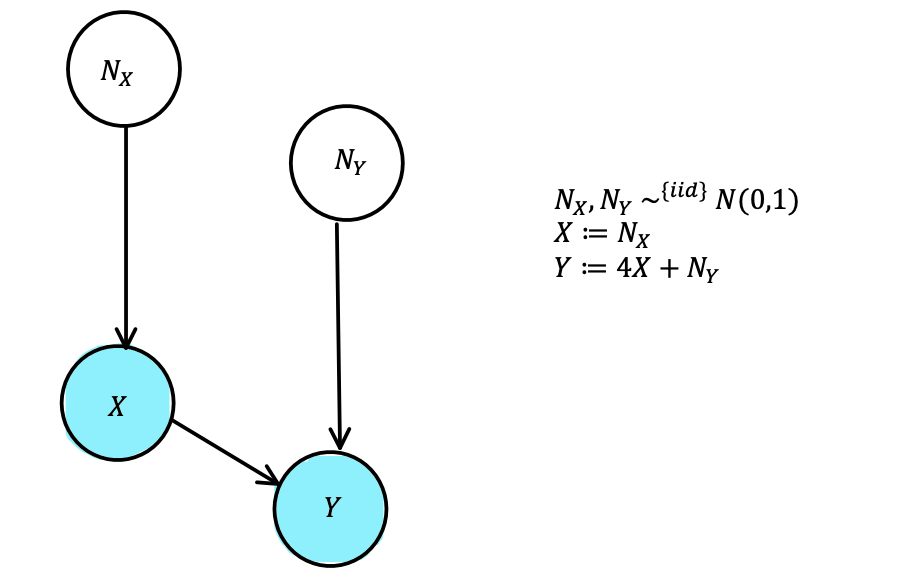

In [54]:
Image(filename='Q4graph.png')

#### 4.2.b $P^{M}_Y$ is a normal distribution with what mean and variance? (2 points)

$P^{M}_Y \sim N(0, 17)$

#### 4.2.c  $P^{M:do(X=2)}_{Y}$ is a normal distribution with what mean and variance? (2 points)


$P^{M:do(X=2)}_Y \sim N(8, 1)$

#### 4.2.d How and why does $P_{Y}^{M:X=2}$ differ or not differ from $P_{Y}^{M:do(X=2)}$? (2 points)

Both will follow $N(8,1)$. 

#### 4.2.e $P_{X}^{M:Y =2}$ is a normal distribution with what mean and variance? Note: Need explanation (2 Points) 

$$\sigma_{XY} = E(XY) - E(X)E(Y)\\
= E(4X^2 + N_Y) + E(X)E(Y)\\
= 4E(X^2) + E(N_Y) + E(X)E(Y)\\
= 4$$

Mean of conditional dist: 
$$\mu_X + \frac{\sigma_{XY}}{\sigma_Y}(y-\mu_Y)\\
= 0 + \frac{4}{17}(2)\\
= 8/17$$

Variance of conditional dist:
$$\sigma_X - \frac{\sigma_{XY}^2}{\sigma_{Y}}\\
1 - \frac{16}{17}\\
\frac{1}{17}
$$

#### 4.2.f $P_{X}^{M:do(Y =2)}$ is a normal distribution with what mean and variance? (2 points)

We have removed the causal edge from $X$ and $N_Y$ to $Y$. So $X$ will not be affected by any value $Y$ takes (they're independent), and follows $N(0,1)$.

#### 4.2.g Write model $P^M_{X,Y}$ in code and generate 10 samples. (3 points)

In [7]:
def model2():
    nx = pyro.sample("Nx", dist.Normal(0.0,1.0))
    ny = pyro.sample("Ny", dist.Normal(0.0,1.0))
    x = pyro.sample("x", dist.Delta(nx))
    y = 4*x + ny
    y = pyro.sample("y", dist.Normal(y, 0.01))

In [101]:
posterior42 = pyro.infer.Importance(model2, num_samples=1000).run()
marginal4x2 = pyro.infer.EmpiricalMarginal(posterior42, "x")
marginal4y2 = pyro.infer.EmpiricalMarginal(posterior42, "y")
x_samples2 = np.array([marginal4x2().item() for _ in range(10)])
y_samples2 = np.array([marginal4y2().item() for _ in range(10)])

In [102]:
x_samples2, y_samples2

(array([-0.86672211,  0.16873279,  1.54806435, -0.79572147,  0.70956147,
        -0.0551317 ,  1.44829369,  0.37792072,  2.04062724,  0.0427765 ]),
 array([ 2.03144622, -2.6664083 ,  1.70807981, -5.66762638,  0.03169022,
        -2.31575871,  7.06672668,  5.74376297,  1.97505295, -3.46270895]))

#### 4.2.h Use the do operator to generate 100 samples from model $P_{Y}^{M:do(X=2)}$ and visualize the results in a histogram. (3 points)

In [25]:
int_model = pyro.do(model2, data={'x':torch.tensor(2)})

In [26]:
posterior_int = pyro.infer.Importance(int_model, num_samples=1000).run()
marginal_y_int = pyro.infer.EmpiricalMarginal(posterior_int, "y")
y_int_samples = np.array([marginal_y_int().item() for _ in range(1000)])

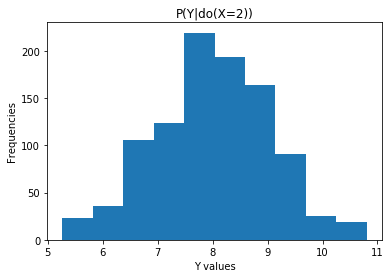

In [27]:
plt.hist(y_int_samples)
plt.title("P(Y|do(X=2))")
plt.xlabel("Y values")
plt.ylabel("Frequencies");

#### 4.2.i Use the condition operator and a Pyro inference algorithm to generate 10 samples from $P_X^{M:Y=2}$. Use one of the Bayesian inference procedures described in the lecture notes. (3 points)

In [28]:
cond_model = pyro.condition(model2, data={"y":torch.tensor(2.)})

In [29]:
posterior_cond = pyro.infer.Importance(cond_model, num_samples=1000).run()
marginal_x_cond = pyro.infer.EmpiricalMarginal(posterior_cond, "x")
x_cond_samples = np.array([marginal_x_cond().item() for _ in range(10)])

In [30]:
x_cond_samples

array([0.48786923, 0.2394169 , 0.51327401, 0.72083217, 0.48786923,
       0.2394169 , 0.41163284, 0.2394169 , 0.48786923, 0.48786923])